In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'VTCNN2_v2_dft_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Discrete Fourier Transform

Each signal is transformed from an I/Q sample using Discrete Fourier Transform, and added as a column to the dataset.

In [7]:
def I_Q_to_DFT(signal):
    complex_IQ_representation = []
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)
        complex_IQ_representation.append(cmplx)
    
    # numpy fft(arr) transforms an array 'arr' of complex numbers using Discrete Fourier Transform
    ffted_cplx = np.fft.fft(complex_IQ_representation)
    return [ffted_cplx.real, ffted_cplx.imag]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_DFT(signal)
    
    # transformed_signal is a train of values
    transformed_signals.append(transformed_signal)

In [9]:
dft_signals_column_dataframe_name = 'DFT signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[dft_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    dft_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding DFT Signals

In [10]:
dataset_df

,IQ signals,DFT signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[-0.060862621969135944, -0.22769021567320955,...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.07303547981427982, 0.21388404694926202, -0...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.07157310681941453, 0.06983173884925772, -0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.06919694535099552, 0.05751631710576523, -0...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.16920786396804033, 0.3561287889109632, 0.3...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[-0.02215634343883721, 0.11752126689233586, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[-0.10105456630867593, -0.10305432796774971, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[-0.0646182048258197, 0.0054176624689576194, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[-0.16591021459316835, 0.001243809761688204, ...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = []

for i in range(0, len(dataset_df.index)):
    signal = []
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[iq_signals_column_dataframe_name][i][1])
    signal.append(dataset_df[dft_signals_column_dataframe_name][i][0])
    signal.append(dataset_df[dft_signals_column_dataframe_name][i][1])
    signals.append(signal)

labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 4, 128)
[4, 128]


In [16]:
model = neural_networks.rml201610a_VTCNN2_v2(in_shp)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 4, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 8, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 3, 256)         33024     
_________________________________________________________________
dropout (Dropout)            (None, 1, 3, 256)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 7, 256)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 3, 80)          82000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 3, 80)          0

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 29:24 - loss: 2.3979

  7/151 [>.............................] - ETA: 1s - loss: 2.3977   

 13/151 [=>............................] - ETA: 1s - loss: 2.3976

 20/151 [==>...........................] - ETA: 1s - loss: 2.3971

 27/151 [====>.........................] - ETA: 1s - loss: 2.3962

 34/151 [=====>........................] - ETA: 0s - loss: 2.3941

 41/151 [=======>......................] - ETA: 0s - loss: 2.3905

 48/151 [========>.....................] - ETA: 0s - loss: 2.3856

 55/151 [=========>....................] - ETA: 0s - loss: 2.3802

 62/151 [===========>..................] - ETA: 0s - loss: 2.3748

 69/151 [============>.................] - ETA: 0s - loss: 2.3695

 76/151 [==============>...............] - ETA: 0s - loss: 2.3645

 83/151 [===============>..............] - ETA: 0s - loss: 2.3598

 90/151 [================>.............] - ETA: 0s - loss: 2.3555

 97/151 [==================>...........] - ETA: 0s - loss: 2.3514

104/151 [===================>..........] - ETA: 0s - loss: 2.3477

111/151 [=====================>........] - ETA: 0s - loss: 2.3441

117/151 [======================>.......] - ETA: 0s - loss: 2.3413

124/151 [=======================>......] - ETA: 0s - loss: 2.3381

131/151 [=========================>....] - ETA: 0s - loss: 2.3350

138/151 [==========================>...] - ETA: 0s - loss: 2.3322

145/151 [===========================>..] - ETA: 0s - loss: 2.3295

151/151 [==============================] - ETA: 0s - loss: 2.3272

151/151 [==============================] - 14s 13ms/step - loss: 2.3269 - val_loss: 2.2030


Epoch 2/100
  1/151 [..............................] - ETA: 1s - loss: 2.2153

  8/151 [>.............................] - ETA: 1s - loss: 2.2156

 15/151 [=>............................] - ETA: 1s - loss: 2.2165

 22/151 [===>..........................] - ETA: 1s - loss: 2.2161

 29/151 [====>.........................] - ETA: 0s - loss: 2.2146

 36/151 [======>.......................] - ETA: 0s - loss: 2.2129

 43/151 [=======>......................] - ETA: 0s - loss: 2.2109

 50/151 [========>.....................] - ETA: 0s - loss: 2.2085

 57/151 [==========>...................] - ETA: 0s - loss: 2.2060

 63/151 [===========>..................] - ETA: 0s - loss: 2.2037



 70/151 [============>.................] - ETA: 0s - loss: 2.2008

 77/151 [==============>...............] - ETA: 0s - loss: 2.1977

 84/151 [===============>..............] - ETA: 0s - loss: 2.1946

 91/151 [=================>............] - ETA: 0s - loss: 2.1914

 98/151 [==================>...........] - ETA: 0s - loss: 2.1882

105/151 [===================>..........] - ETA: 0s - loss: 2.1850

112/151 [=====================>........] - ETA: 0s - loss: 2.1818

119/151 [======================>.......] - ETA: 0s - loss: 2.1786

126/151 [========================>.....] - ETA: 0s - loss: 2.1754

133/151 [=========================>....] - ETA: 0s - loss: 2.1723

140/151 [==========================>...] - ETA: 0s - loss: 2.1692

147/151 [============================>.] - ETA: 0s - loss: 2.1662

151/151 [==============================] - 1s 9ms/step - loss: 2.1641 - val_loss: 1.9540


Epoch 3/100
  1/151 [..............................] - ETA: 1s - loss: 2.0086

  8/151 [>.............................] - ETA: 1s - loss: 1.9982

 14/151 [=>............................] - ETA: 1s - loss: 1.9979

 21/151 [===>..........................] - ETA: 1s - loss: 1.9959

 28/151 [====>.........................] - ETA: 0s - loss: 1.9946

 35/151 [=====>........................] - ETA: 0s - loss: 1.9937

 42/151 [=======>......................] - ETA: 0s - loss: 1.9927

 48/151 [========>.....................] - ETA: 0s - loss: 1.9920

 55/151 [=========>....................] - ETA: 0s - loss: 1.9912

 62/151 [===========>..................] - ETA: 0s - loss: 1.9906

 69/151 [============>.................] - ETA: 0s - loss: 1.9897

 76/151 [==============>...............] - ETA: 0s - loss: 1.9889

 83/151 [===============>..............] - ETA: 0s - loss: 1.9882

 90/151 [================>.............] - ETA: 0s - loss: 1.9875

 97/151 [==================>...........] - ETA: 0s - loss: 1.9868

104/151 [===================>..........] - ETA: 0s - loss: 1.9860

111/151 [=====================>........] - ETA: 0s - loss: 1.9852

118/151 [======================>.......] - ETA: 0s - loss: 1.9844

125/151 [=======================>......] - ETA: 0s - loss: 1.9836

132/151 [=========================>....] - ETA: 0s - loss: 1.9828

139/151 [==========================>...] - ETA: 0s - loss: 1.9820

146/151 [============================>.] - ETA: 0s - loss: 1.9813

151/151 [==============================] - 1s 9ms/step - loss: 1.9806 - val_loss: 1.8590


Epoch 4/100
  1/151 [..............................] - ETA: 1s - loss: 1.9517

  8/151 [>.............................] - ETA: 1s - loss: 1.9383

 15/151 [=>............................] - ETA: 1s - loss: 1.9305

 22/151 [===>..........................] - ETA: 1s - loss: 1.9256

 29/151 [====>.........................] - ETA: 0s - loss: 1.9227

 36/151 [======>.......................] - ETA: 0s - loss: 1.9210

 43/151 [=======>......................] - ETA: 0s - loss: 1.9195

 50/151 [========>.....................] - ETA: 0s - loss: 1.9183

 57/151 [==========>...................] - ETA: 0s - loss: 1.9171

 64/151 [===========>..................] - ETA: 0s - loss: 1.9160

 71/151 [=============>................] - ETA: 0s - loss: 1.9150

 78/151 [==============>...............] - ETA: 0s - loss: 1.9141

 85/151 [===============>..............] - ETA: 0s - loss: 1.9133

 92/151 [=================>............] - ETA: 0s - loss: 1.9126

 99/151 [==================>...........] - ETA: 0s - loss: 1.9120

106/151 [====================>.........] - ETA: 0s - loss: 1.9114

113/151 [=====================>........] - ETA: 0s - loss: 1.9108

120/151 [======================>.......] - ETA: 0s - loss: 1.9102

127/151 [========================>.....] - ETA: 0s - loss: 1.9096

134/151 [=========================>....] - ETA: 0s - loss: 1.9090

141/151 [===========================>..] - ETA: 0s - loss: 1.9084

148/151 [============================>.] - ETA: 0s - loss: 1.9078

151/151 [==============================] - 1s 9ms/step - loss: 1.9075 - val_loss: 1.8037


Epoch 5/100
  1/151 [..............................] - ETA: 1s - loss: 1.8381

  8/151 [>.............................] - ETA: 1s - loss: 1.8727

 15/151 [=>............................] - ETA: 1s - loss: 1.8744

 22/151 [===>..........................] - ETA: 1s - loss: 1.8746

 29/151 [====>.........................] - ETA: 0s - loss: 1.8737

 36/151 [======>.......................] - ETA: 0s - loss: 1.8731

 43/151 [=======>......................] - ETA: 0s - loss: 1.8723

 50/151 [========>.....................] - ETA: 0s - loss: 1.8717

 57/151 [==========>...................] - ETA: 0s - loss: 1.8710

 64/151 [===========>..................] - ETA: 0s - loss: 1.8704

 71/151 [=============>................] - ETA: 0s - loss: 1.8699

 78/151 [==============>...............] - ETA: 0s - loss: 1.8693

 85/151 [===============>..............] - ETA: 0s - loss: 1.8689

 92/151 [=================>............] - ETA: 0s - loss: 1.8685

 99/151 [==================>...........] - ETA: 0s - loss: 1.8681

106/151 [====================>.........] - ETA: 0s - loss: 1.8677

113/151 [=====================>........] - ETA: 0s - loss: 1.8674

120/151 [======================>.......] - ETA: 0s - loss: 1.8672

127/151 [========================>.....] - ETA: 0s - loss: 1.8669

134/151 [=========================>....] - ETA: 0s - loss: 1.8666

141/151 [===========================>..] - ETA: 0s - loss: 1.8663

148/151 [============================>.] - ETA: 0s - loss: 1.8661

151/151 [==============================] - 1s 9ms/step - loss: 1.8659 - val_loss: 1.7853


Epoch 6/100
  1/151 [..............................] - ETA: 1s - loss: 1.8517

  8/151 [>.............................] - ETA: 1s - loss: 1.8574

 14/151 [=>............................] - ETA: 1s - loss: 1.8543

 21/151 [===>..........................] - ETA: 1s - loss: 1.8520

 28/151 [====>.........................] - ETA: 0s - loss: 1.8510

 35/151 [=====>........................] - ETA: 0s - loss: 1.8506

 42/151 [=======>......................] - ETA: 0s - loss: 1.8501

 49/151 [========>.....................] - ETA: 0s - loss: 1.8498

 56/151 [==========>...................] - ETA: 0s - loss: 1.8495

 63/151 [===========>..................] - ETA: 0s - loss: 1.8491

 70/151 [============>.................] - ETA: 0s - loss: 1.8488

 77/151 [==============>...............] - ETA: 0s - loss: 1.8486

 84/151 [===============>..............] - ETA: 0s - loss: 1.8484

 91/151 [=================>............] - ETA: 0s - loss: 1.8481

 98/151 [==================>...........] - ETA: 0s - loss: 1.8479

105/151 [===================>..........] - ETA: 0s - loss: 1.8477

112/151 [=====================>........] - ETA: 0s - loss: 1.8474

119/151 [======================>.......] - ETA: 0s - loss: 1.8472

126/151 [========================>.....] - ETA: 0s - loss: 1.8469

133/151 [=========================>....] - ETA: 0s - loss: 1.8467

140/151 [==========================>...] - ETA: 0s - loss: 1.8465

147/151 [============================>.] - ETA: 0s - loss: 1.8463

151/151 [==============================] - 1s 9ms/step - loss: 1.8462 - val_loss: 1.7675


Epoch 7/100
  1/151 [..............................] - ETA: 1s - loss: 1.8825

  8/151 [>.............................] - ETA: 1s - loss: 1.8490

 15/151 [=>............................] - ETA: 1s - loss: 1.8442

 22/151 [===>..........................] - ETA: 1s - loss: 1.8416

 29/151 [====>.........................] - ETA: 0s - loss: 1.8407

 36/151 [======>.......................] - ETA: 0s - loss: 1.8402

 43/151 [=======>......................] - ETA: 0s - loss: 1.8397

 50/151 [========>.....................] - ETA: 0s - loss: 1.8391

 57/151 [==========>...................] - ETA: 0s - loss: 1.8388

 64/151 [===========>..................] - ETA: 0s - loss: 1.8386

 71/151 [=============>................] - ETA: 0s - loss: 1.8383

 78/151 [==============>...............] - ETA: 0s - loss: 1.8380

 85/151 [===============>..............] - ETA: 0s - loss: 1.8378

 92/151 [=================>............] - ETA: 0s - loss: 1.8375

 99/151 [==================>...........] - ETA: 0s - loss: 1.8372

106/151 [====================>.........] - ETA: 0s - loss: 1.8369

113/151 [=====================>........] - ETA: 0s - loss: 1.8366

120/151 [======================>.......] - ETA: 0s - loss: 1.8364

127/151 [========================>.....] - ETA: 0s - loss: 1.8361

133/151 [=========================>....] - ETA: 0s - loss: 1.8359

140/151 [==========================>...] - ETA: 0s - loss: 1.8357

147/151 [============================>.] - ETA: 0s - loss: 1.8355

151/151 [==============================] - 1s 9ms/step - loss: 1.8353 - val_loss: 1.7570


Epoch 8/100
  1/151 [..............................] - ETA: 1s - loss: 1.7945

  8/151 [>.............................] - ETA: 1s - loss: 1.8173

 15/151 [=>............................] - ETA: 1s - loss: 1.8231

 22/151 [===>..........................] - ETA: 1s - loss: 1.8232

 29/151 [====>.........................] - ETA: 0s - loss: 1.8230

 36/151 [======>.......................] - ETA: 0s - loss: 1.8224

 43/151 [=======>......................] - ETA: 0s - loss: 1.8220

 49/151 [========>.....................] - ETA: 0s - loss: 1.8217

 56/151 [==========>...................] - ETA: 0s - loss: 1.8215

 63/151 [===========>..................] - ETA: 0s - loss: 1.8215

 70/151 [============>.................] - ETA: 0s - loss: 1.8215

 77/151 [==============>...............] - ETA: 0s - loss: 1.8215

 84/151 [===============>..............] - ETA: 0s - loss: 1.8214

 91/151 [=================>............] - ETA: 0s - loss: 1.8213

 98/151 [==================>...........] - ETA: 0s - loss: 1.8213

105/151 [===================>..........] - ETA: 0s - loss: 1.8213

112/151 [=====================>........] - ETA: 0s - loss: 1.8212

119/151 [======================>.......] - ETA: 0s - loss: 1.8211

126/151 [========================>.....] - ETA: 0s - loss: 1.8211

133/151 [=========================>....] - ETA: 0s - loss: 1.8211

140/151 [==========================>...] - ETA: 0s - loss: 1.8211

147/151 [============================>.] - ETA: 0s - loss: 1.8211

151/151 [==============================] - 1s 9ms/step - loss: 1.8211 - val_loss: 1.7534


Epoch 9/100
  1/151 [..............................] - ETA: 1s - loss: 1.8359

  8/151 [>.............................] - ETA: 1s - loss: 1.8155

 15/151 [=>............................] - ETA: 1s - loss: 1.8131

 22/151 [===>..........................] - ETA: 1s - loss: 1.8126

 29/151 [====>.........................] - ETA: 0s - loss: 1.8131

 36/151 [======>.......................] - ETA: 0s - loss: 1.8138

 43/151 [=======>......................] - ETA: 0s - loss: 1.8140

 50/151 [========>.....................] - ETA: 0s - loss: 1.8145

 57/151 [==========>...................] - ETA: 0s - loss: 1.8147

 64/151 [===========>..................] - ETA: 0s - loss: 1.8150

 71/151 [=============>................] - ETA: 0s - loss: 1.8153

 78/151 [==============>...............] - ETA: 0s - loss: 1.8155

 85/151 [===============>..............] - ETA: 0s - loss: 1.8157

 92/151 [=================>............] - ETA: 0s - loss: 1.8157

 99/151 [==================>...........] - ETA: 0s - loss: 1.8157

106/151 [====================>.........] - ETA: 0s - loss: 1.8157

113/151 [=====================>........] - ETA: 0s - loss: 1.8156

119/151 [======================>.......] - ETA: 0s - loss: 1.8155

126/151 [========================>.....] - ETA: 0s - loss: 1.8155

133/151 [=========================>....] - ETA: 0s - loss: 1.8154

140/151 [==========================>...] - ETA: 0s - loss: 1.8153

146/151 [============================>.] - ETA: 0s - loss: 1.8153

151/151 [==============================] - 1s 9ms/step - loss: 1.8152 - val_loss: 1.7463


Epoch 10/100
  1/151 [..............................] - ETA: 1s - loss: 1.8195

  7/151 [>.............................] - ETA: 1s - loss: 1.8106

 14/151 [=>............................] - ETA: 1s - loss: 1.8096

 21/151 [===>..........................] - ETA: 1s - loss: 1.8089

 28/151 [====>.........................] - ETA: 0s - loss: 1.8086

 35/151 [=====>........................] - ETA: 0s - loss: 1.8081

 42/151 [=======>......................] - ETA: 0s - loss: 1.8074

 49/151 [========>.....................] - ETA: 0s - loss: 1.8072

 56/151 [==========>...................] - ETA: 0s - loss: 1.8067

 63/151 [===========>..................] - ETA: 0s - loss: 1.8062

 70/151 [============>.................] - ETA: 0s - loss: 1.8058

 77/151 [==============>...............] - ETA: 0s - loss: 1.8057

 84/151 [===============>..............] - ETA: 0s - loss: 1.8057

 91/151 [=================>............] - ETA: 0s - loss: 1.8057

 98/151 [==================>...........] - ETA: 0s - loss: 1.8057

105/151 [===================>..........] - ETA: 0s - loss: 1.8057

112/151 [=====================>........] - ETA: 0s - loss: 1.8057

119/151 [======================>.......] - ETA: 0s - loss: 1.8057

126/151 [========================>.....] - ETA: 0s - loss: 1.8057

133/151 [=========================>....] - ETA: 0s - loss: 1.8056

140/151 [==========================>...] - ETA: 0s - loss: 1.8056

147/151 [============================>.] - ETA: 0s - loss: 1.8057

151/151 [==============================] - 1s 9ms/step - loss: 1.8056 - val_loss: 1.7414


Epoch 11/100
  1/151 [..............................] - ETA: 1s - loss: 1.8203

  8/151 [>.............................] - ETA: 1s - loss: 1.8163

 15/151 [=>............................] - ETA: 1s - loss: 1.8129

 22/151 [===>..........................] - ETA: 1s - loss: 1.8120

 29/151 [====>.........................] - ETA: 0s - loss: 1.8115

 35/151 [=====>........................] - ETA: 0s - loss: 1.8110

 42/151 [=======>......................] - ETA: 0s - loss: 1.8106

 49/151 [========>.....................] - ETA: 0s - loss: 1.8102

 56/151 [==========>...................] - ETA: 0s - loss: 1.8099

 63/151 [===========>..................] - ETA: 0s - loss: 1.8094

 70/151 [============>.................] - ETA: 0s - loss: 1.8091

 77/151 [==============>...............] - ETA: 0s - loss: 1.8088

 84/151 [===============>..............] - ETA: 0s - loss: 1.8085

 91/151 [=================>............] - ETA: 0s - loss: 1.8082

 98/151 [==================>...........] - ETA: 0s - loss: 1.8079

105/151 [===================>..........] - ETA: 0s - loss: 1.8076

112/151 [=====================>........] - ETA: 0s - loss: 1.8073

119/151 [======================>.......] - ETA: 0s - loss: 1.8069

126/151 [========================>.....] - ETA: 0s - loss: 1.8066

133/151 [=========================>....] - ETA: 0s - loss: 1.8064

140/151 [==========================>...] - ETA: 0s - loss: 1.8062

147/151 [============================>.] - ETA: 0s - loss: 1.8059

151/151 [==============================] - 1s 9ms/step - loss: 1.8057 - val_loss: 1.7358


Epoch 12/100
  1/151 [..............................] - ETA: 1s - loss: 1.8231

  8/151 [>.............................] - ETA: 1s - loss: 1.8100

 14/151 [=>............................] - ETA: 1s - loss: 1.8061

 21/151 [===>..........................] - ETA: 1s - loss: 1.8045

 28/151 [====>.........................] - ETA: 0s - loss: 1.8032

 35/151 [=====>........................] - ETA: 0s - loss: 1.8019

 42/151 [=======>......................] - ETA: 0s - loss: 1.8012

 49/151 [========>.....................] - ETA: 0s - loss: 1.8008

 55/151 [=========>....................] - ETA: 0s - loss: 1.8003

 62/151 [===========>..................] - ETA: 0s - loss: 1.7997

 69/151 [============>.................] - ETA: 0s - loss: 1.7994

 76/151 [==============>...............] - ETA: 0s - loss: 1.7991

 83/151 [===============>..............] - ETA: 0s - loss: 1.7988

 90/151 [================>.............] - ETA: 0s - loss: 1.7985

 96/151 [==================>...........] - ETA: 0s - loss: 1.7983

103/151 [===================>..........] - ETA: 0s - loss: 1.7981

110/151 [====================>.........] - ETA: 0s - loss: 1.7979

117/151 [======================>.......] - ETA: 0s - loss: 1.7977

124/151 [=======================>......] - ETA: 0s - loss: 1.7976

131/151 [=========================>....] - ETA: 0s - loss: 1.7975

138/151 [==========================>...] - ETA: 0s - loss: 1.7974

145/151 [===========================>..] - ETA: 0s - loss: 1.7973

151/151 [==============================] - 1s 9ms/step - loss: 1.7972 - val_loss: 1.7335


Epoch 13/100
  1/151 [..............................] - ETA: 1s - loss: 1.8060

  8/151 [>.............................] - ETA: 1s - loss: 1.7848

 15/151 [=>............................] - ETA: 1s - loss: 1.7875

 22/151 [===>..........................] - ETA: 1s - loss: 1.7885

 29/151 [====>.........................] - ETA: 0s - loss: 1.7885

 36/151 [======>.......................] - ETA: 0s - loss: 1.7888

 43/151 [=======>......................] - ETA: 0s - loss: 1.7890

 50/151 [========>.....................] - ETA: 0s - loss: 1.7889

 57/151 [==========>...................] - ETA: 0s - loss: 1.7890

 64/151 [===========>..................] - ETA: 0s - loss: 1.7892

 71/151 [=============>................] - ETA: 0s - loss: 1.7894

 78/151 [==============>...............] - ETA: 0s - loss: 1.7897

 85/151 [===============>..............] - ETA: 0s - loss: 1.7900

 92/151 [=================>............] - ETA: 0s - loss: 1.7903

 99/151 [==================>...........] - ETA: 0s - loss: 1.7904

106/151 [====================>.........] - ETA: 0s - loss: 1.7905

113/151 [=====================>........] - ETA: 0s - loss: 1.7906

120/151 [======================>.......] - ETA: 0s - loss: 1.7906

127/151 [========================>.....] - ETA: 0s - loss: 1.7906

134/151 [=========================>....] - ETA: 0s - loss: 1.7907

141/151 [===========================>..] - ETA: 0s - loss: 1.7907

148/151 [============================>.] - ETA: 0s - loss: 1.7908

151/151 [==============================] - 1s 9ms/step - loss: 1.7908 - val_loss: 1.7312


Epoch 14/100
  1/151 [..............................] - ETA: 1s - loss: 1.7179

  8/151 [>.............................] - ETA: 1s - loss: 1.7772

 15/151 [=>............................] - ETA: 1s - loss: 1.7847

 22/151 [===>..........................] - ETA: 1s - loss: 1.7869

 29/151 [====>.........................] - ETA: 0s - loss: 1.7882

 36/151 [======>.......................] - ETA: 0s - loss: 1.7892

 43/151 [=======>......................] - ETA: 0s - loss: 1.7896

 50/151 [========>.....................] - ETA: 0s - loss: 1.7895

 57/151 [==========>...................] - ETA: 0s - loss: 1.7893

 63/151 [===========>..................] - ETA: 0s - loss: 1.7891

 70/151 [============>.................] - ETA: 0s - loss: 1.7889

 77/151 [==============>...............] - ETA: 0s - loss: 1.7888

 84/151 [===============>..............] - ETA: 0s - loss: 1.7887

 91/151 [=================>............] - ETA: 0s - loss: 1.7886

 98/151 [==================>...........] - ETA: 0s - loss: 1.7886

105/151 [===================>..........] - ETA: 0s - loss: 1.7885

112/151 [=====================>........] - ETA: 0s - loss: 1.7885

119/151 [======================>.......] - ETA: 0s - loss: 1.7884

126/151 [========================>.....] - ETA: 0s - loss: 1.7884

133/151 [=========================>....] - ETA: 0s - loss: 1.7884

137/151 [==========================>...] - ETA: 0s - loss: 1.7883

141/151 [===========================>..] - ETA: 0s - loss: 1.7883

147/151 [============================>.] - ETA: 0s - loss: 1.7883

151/151 [==============================] - 1s 10ms/step - loss: 1.7882 - val_loss: 1.7251


Epoch 15/100
  1/151 [..............................] - ETA: 1s - loss: 1.8078

  8/151 [>.............................] - ETA: 1s - loss: 1.7830

 15/151 [=>............................] - ETA: 1s - loss: 1.7816

 22/151 [===>..........................] - ETA: 1s - loss: 1.7824

 29/151 [====>.........................] - ETA: 0s - loss: 1.7829

 36/151 [======>.......................] - ETA: 0s - loss: 1.7833

 43/151 [=======>......................] - ETA: 0s - loss: 1.7836

 50/151 [========>.....................] - ETA: 0s - loss: 1.7841

 57/151 [==========>...................] - ETA: 0s - loss: 1.7843

 64/151 [===========>..................] - ETA: 0s - loss: 1.7844

 71/151 [=============>................] - ETA: 0s - loss: 1.7845

 78/151 [==============>...............] - ETA: 0s - loss: 1.7846

 84/151 [===============>..............] - ETA: 0s - loss: 1.7846

 91/151 [=================>............] - ETA: 0s - loss: 1.7845

 98/151 [==================>...........] - ETA: 0s - loss: 1.7844

105/151 [===================>..........] - ETA: 0s - loss: 1.7843

112/151 [=====================>........] - ETA: 0s - loss: 1.7842

119/151 [======================>.......] - ETA: 0s - loss: 1.7842

126/151 [========================>.....] - ETA: 0s - loss: 1.7841

133/151 [=========================>....] - ETA: 0s - loss: 1.7840

140/151 [==========================>...] - ETA: 0s - loss: 1.7839

147/151 [============================>.] - ETA: 0s - loss: 1.7839

151/151 [==============================] - 1s 9ms/step - loss: 1.7838 - val_loss: 1.7272


Epoch 16/100
  1/151 [..............................] - ETA: 1s - loss: 1.8299

  8/151 [>.............................] - ETA: 1s - loss: 1.7925

 15/151 [=>............................] - ETA: 1s - loss: 1.7862

 22/151 [===>..........................] - ETA: 1s - loss: 1.7854

 29/151 [====>.........................] - ETA: 0s - loss: 1.7855

 36/151 [======>.......................] - ETA: 0s - loss: 1.7851

 43/151 [=======>......................] - ETA: 0s - loss: 1.7849

 50/151 [========>.....................] - ETA: 0s - loss: 1.7846

 57/151 [==========>...................] - ETA: 0s - loss: 1.7842

 64/151 [===========>..................] - ETA: 0s - loss: 1.7839

 71/151 [=============>................] - ETA: 0s - loss: 1.7837

 78/151 [==============>...............] - ETA: 0s - loss: 1.7835

 85/151 [===============>..............] - ETA: 0s - loss: 1.7833

 92/151 [=================>............] - ETA: 0s - loss: 1.7831

 99/151 [==================>...........] - ETA: 0s - loss: 1.7830

106/151 [====================>.........] - ETA: 0s - loss: 1.7828

113/151 [=====================>........] - ETA: 0s - loss: 1.7827

120/151 [======================>.......] - ETA: 0s - loss: 1.7826

127/151 [========================>.....] - ETA: 0s - loss: 1.7826

134/151 [=========================>....] - ETA: 0s - loss: 1.7825

141/151 [===========================>..] - ETA: 0s - loss: 1.7825

148/151 [============================>.] - ETA: 0s - loss: 1.7824

151/151 [==============================] - 1s 9ms/step - loss: 1.7824 - val_loss: 1.7229


Epoch 17/100
  1/151 [..............................] - ETA: 1s - loss: 1.7884

  8/151 [>.............................] - ETA: 1s - loss: 1.7831

 15/151 [=>............................] - ETA: 1s - loss: 1.7812

 21/151 [===>..........................] - ETA: 1s - loss: 1.7794

 28/151 [====>.........................] - ETA: 0s - loss: 1.7788

 35/151 [=====>........................] - ETA: 0s - loss: 1.7787

 42/151 [=======>......................] - ETA: 0s - loss: 1.7785

 49/151 [========>.....................] - ETA: 0s - loss: 1.7783

 56/151 [==========>...................] - ETA: 0s - loss: 1.7782

 63/151 [===========>..................] - ETA: 0s - loss: 1.7782

 70/151 [============>.................] - ETA: 0s - loss: 1.7780

 77/151 [==============>...............] - ETA: 0s - loss: 1.7776

 84/151 [===============>..............] - ETA: 0s - loss: 1.7772

 91/151 [=================>............] - ETA: 0s - loss: 1.7768

 98/151 [==================>...........] - ETA: 0s - loss: 1.7765

105/151 [===================>..........] - ETA: 0s - loss: 1.7763

112/151 [=====================>........] - ETA: 0s - loss: 1.7762

118/151 [======================>.......] - ETA: 0s - loss: 1.7762

125/151 [=======================>......] - ETA: 0s - loss: 1.7762

132/151 [=========================>....] - ETA: 0s - loss: 1.7762

139/151 [==========================>...] - ETA: 0s - loss: 1.7762

145/151 [===========================>..] - ETA: 0s - loss: 1.7762

151/151 [==============================] - 1s 9ms/step - loss: 1.7763 - val_loss: 1.7232


Epoch 18/100
  1/151 [..............................] - ETA: 1s - loss: 1.7622

  8/151 [>.............................] - ETA: 1s - loss: 1.7822

 15/151 [=>............................] - ETA: 1s - loss: 1.7779

 22/151 [===>..........................] - ETA: 1s - loss: 1.7772

 29/151 [====>.........................] - ETA: 0s - loss: 1.7762

 36/151 [======>.......................] - ETA: 0s - loss: 1.7756

 43/151 [=======>......................] - ETA: 0s - loss: 1.7751

 50/151 [========>.....................] - ETA: 0s - loss: 1.7748

 57/151 [==========>...................] - ETA: 0s - loss: 1.7750

 64/151 [===========>..................] - ETA: 0s - loss: 1.7752

 71/151 [=============>................] - ETA: 0s - loss: 1.7752

 78/151 [==============>...............] - ETA: 0s - loss: 1.7752

 85/151 [===============>..............] - ETA: 0s - loss: 1.7752

 92/151 [=================>............] - ETA: 0s - loss: 1.7751

 99/151 [==================>...........] - ETA: 0s - loss: 1.7750

106/151 [====================>.........] - ETA: 0s - loss: 1.7749

113/151 [=====================>........] - ETA: 0s - loss: 1.7747

120/151 [======================>.......] - ETA: 0s - loss: 1.7746

127/151 [========================>.....] - ETA: 0s - loss: 1.7746

134/151 [=========================>....] - ETA: 0s - loss: 1.7745

141/151 [===========================>..] - ETA: 0s - loss: 1.7745

148/151 [============================>.] - ETA: 0s - loss: 1.7744

151/151 [==============================] - 1s 9ms/step - loss: 1.7744 - val_loss: 1.7175


Epoch 19/100
  1/151 [..............................] - ETA: 1s - loss: 1.8002

  8/151 [>.............................] - ETA: 1s - loss: 1.7859

 15/151 [=>............................] - ETA: 1s - loss: 1.7791

 22/151 [===>..........................] - ETA: 1s - loss: 1.7766

 29/151 [====>.........................] - ETA: 0s - loss: 1.7754

 36/151 [======>.......................] - ETA: 0s - loss: 1.7745

 43/151 [=======>......................] - ETA: 0s - loss: 1.7742

 50/151 [========>.....................] - ETA: 0s - loss: 1.7738

 57/151 [==========>...................] - ETA: 0s - loss: 1.7736

 64/151 [===========>..................] - ETA: 0s - loss: 1.7733

 71/151 [=============>................] - ETA: 0s - loss: 1.7732

 78/151 [==============>...............] - ETA: 0s - loss: 1.7730

 85/151 [===============>..............] - ETA: 0s - loss: 1.7727

 92/151 [=================>............] - ETA: 0s - loss: 1.7724

 99/151 [==================>...........] - ETA: 0s - loss: 1.7722



106/151 [====================>.........] - ETA: 0s - loss: 1.7720

113/151 [=====================>........] - ETA: 0s - loss: 1.7719

120/151 [======================>.......] - ETA: 0s - loss: 1.7717

127/151 [========================>.....] - ETA: 0s - loss: 1.7717

134/151 [=========================>....] - ETA: 0s - loss: 1.7717

141/151 [===========================>..] - ETA: 0s - loss: 1.7716

148/151 [============================>.] - ETA: 0s - loss: 1.7716

151/151 [==============================] - 1s 9ms/step - loss: 1.7716 - val_loss: 1.7143


Epoch 20/100
  1/151 [..............................] - ETA: 2s - loss: 1.7812

  8/151 [>.............................] - ETA: 1s - loss: 1.7742

 15/151 [=>............................] - ETA: 1s - loss: 1.7736

 22/151 [===>..........................] - ETA: 1s - loss: 1.7715

 29/151 [====>.........................] - ETA: 0s - loss: 1.7704

 36/151 [======>.......................] - ETA: 0s - loss: 1.7691

 43/151 [=======>......................] - ETA: 0s - loss: 1.7682

 50/151 [========>.....................] - ETA: 0s - loss: 1.7677

 57/151 [==========>...................] - ETA: 0s - loss: 1.7676

 64/151 [===========>..................] - ETA: 0s - loss: 1.7675

 71/151 [=============>................] - ETA: 0s - loss: 1.7674

 78/151 [==============>...............] - ETA: 0s - loss: 1.7673

 85/151 [===============>..............] - ETA: 0s - loss: 1.7673

 92/151 [=================>............] - ETA: 0s - loss: 1.7673

 99/151 [==================>...........] - ETA: 0s - loss: 1.7673

106/151 [====================>.........] - ETA: 0s - loss: 1.7673

113/151 [=====================>........] - ETA: 0s - loss: 1.7673

120/151 [======================>.......] - ETA: 0s - loss: 1.7673

127/151 [========================>.....] - ETA: 0s - loss: 1.7673

134/151 [=========================>....] - ETA: 0s - loss: 1.7672



141/151 [===========================>..] - ETA: 0s - loss: 1.7673

148/151 [============================>.] - ETA: 0s - loss: 1.7673

151/151 [==============================] - 1s 9ms/step - loss: 1.7673 - val_loss: 1.7182


Epoch 21/100
  1/151 [..............................] - ETA: 1s - loss: 1.7558

  8/151 [>.............................] - ETA: 1s - loss: 1.7687

 15/151 [=>............................] - ETA: 1s - loss: 1.7702

 22/151 [===>..........................] - ETA: 1s - loss: 1.7705

 29/151 [====>.........................] - ETA: 0s - loss: 1.7708

 36/151 [======>.......................] - ETA: 0s - loss: 1.7705

 43/151 [=======>......................] - ETA: 0s - loss: 1.7700

 50/151 [========>.....................] - ETA: 0s - loss: 1.7696

 57/151 [==========>...................] - ETA: 0s - loss: 1.7691

 64/151 [===========>..................] - ETA: 0s - loss: 1.7688

 71/151 [=============>................] - ETA: 0s - loss: 1.7686

 78/151 [==============>...............] - ETA: 0s - loss: 1.7685

 85/151 [===============>..............] - ETA: 0s - loss: 1.7684

 92/151 [=================>............] - ETA: 0s - loss: 1.7682

 99/151 [==================>...........] - ETA: 0s - loss: 1.7681

106/151 [====================>.........] - ETA: 0s - loss: 1.7680

113/151 [=====================>........] - ETA: 0s - loss: 1.7680

120/151 [======================>.......] - ETA: 0s - loss: 1.7680

127/151 [========================>.....] - ETA: 0s - loss: 1.7680

134/151 [=========================>....] - ETA: 0s - loss: 1.7679

141/151 [===========================>..] - ETA: 0s - loss: 1.7678

148/151 [============================>.] - ETA: 0s - loss: 1.7678

151/151 [==============================] - 1s 9ms/step - loss: 1.7677 - val_loss: 1.7132


Epoch 22/100
  1/151 [..............................] - ETA: 1s - loss: 1.8045

  8/151 [>.............................] - ETA: 1s - loss: 1.7634

 15/151 [=>............................] - ETA: 1s - loss: 1.7614

 22/151 [===>..........................] - ETA: 1s - loss: 1.7615

 29/151 [====>.........................] - ETA: 0s - loss: 1.7621

 36/151 [======>.......................] - ETA: 0s - loss: 1.7618

 43/151 [=======>......................] - ETA: 0s - loss: 1.7615

 50/151 [========>.....................] - ETA: 0s - loss: 1.7612

 57/151 [==========>...................] - ETA: 0s - loss: 1.7610

 64/151 [===========>..................] - ETA: 0s - loss: 1.7608

 71/151 [=============>................] - ETA: 0s - loss: 1.7608

 78/151 [==============>...............] - ETA: 0s - loss: 1.7610

 85/151 [===============>..............] - ETA: 0s - loss: 1.7611

 92/151 [=================>............] - ETA: 0s - loss: 1.7613

 99/151 [==================>...........] - ETA: 0s - loss: 1.7614

106/151 [====================>.........] - ETA: 0s - loss: 1.7616

113/151 [=====================>........] - ETA: 0s - loss: 1.7618

120/151 [======================>.......] - ETA: 0s - loss: 1.7619

127/151 [========================>.....] - ETA: 0s - loss: 1.7621

134/151 [=========================>....] - ETA: 0s - loss: 1.7623

141/151 [===========================>..] - ETA: 0s - loss: 1.7624

148/151 [============================>.] - ETA: 0s - loss: 1.7625

151/151 [==============================] - 1s 9ms/step - loss: 1.7626 - val_loss: 1.7182


Epoch 23/100
  1/151 [..............................] - ETA: 1s - loss: 1.7424

  8/151 [>.............................] - ETA: 1s - loss: 1.7553

 15/151 [=>............................] - ETA: 1s - loss: 1.7580

 22/151 [===>..........................] - ETA: 1s - loss: 1.7575

 29/151 [====>.........................] - ETA: 0s - loss: 1.7581

 36/151 [======>.......................] - ETA: 0s - loss: 1.7579

 43/151 [=======>......................] - ETA: 0s - loss: 1.7575

 50/151 [========>.....................] - ETA: 0s - loss: 1.7575

 57/151 [==========>...................] - ETA: 0s - loss: 1.7577

 64/151 [===========>..................] - ETA: 0s - loss: 1.7581

 71/151 [=============>................] - ETA: 0s - loss: 1.7586

 78/151 [==============>...............] - ETA: 0s - loss: 1.7590

 85/151 [===============>..............] - ETA: 0s - loss: 1.7592

 92/151 [=================>............] - ETA: 0s - loss: 1.7594

 99/151 [==================>...........] - ETA: 0s - loss: 1.7595

106/151 [====================>.........] - ETA: 0s - loss: 1.7596

113/151 [=====================>........] - ETA: 0s - loss: 1.7597

120/151 [======================>.......] - ETA: 0s - loss: 1.7598

127/151 [========================>.....] - ETA: 0s - loss: 1.7598

134/151 [=========================>....] - ETA: 0s - loss: 1.7599

141/151 [===========================>..] - ETA: 0s - loss: 1.7600

148/151 [============================>.] - ETA: 0s - loss: 1.7601

151/151 [==============================] - 1s 9ms/step - loss: 1.7601 - val_loss: 1.7115


Epoch 24/100
  1/151 [..............................] - ETA: 1s - loss: 1.7778

  8/151 [>.............................] - ETA: 1s - loss: 1.7621

 14/151 [=>............................] - ETA: 1s - loss: 1.7598

 21/151 [===>..........................] - ETA: 1s - loss: 1.7561

 28/151 [====>.........................] - ETA: 0s - loss: 1.7546

 35/151 [=====>........................] - ETA: 0s - loss: 1.7540

 42/151 [=======>......................] - ETA: 0s - loss: 1.7535

 49/151 [========>.....................] - ETA: 0s - loss: 1.7532

 56/151 [==========>...................] - ETA: 0s - loss: 1.7532

 63/151 [===========>..................] - ETA: 0s - loss: 1.7532

 70/151 [============>.................] - ETA: 0s - loss: 1.7531

 77/151 [==============>...............] - ETA: 0s - loss: 1.7532

 84/151 [===============>..............] - ETA: 0s - loss: 1.7533

 91/151 [=================>............] - ETA: 0s - loss: 1.7534

 98/151 [==================>...........] - ETA: 0s - loss: 1.7536

105/151 [===================>..........] - ETA: 0s - loss: 1.7538

112/151 [=====================>........] - ETA: 0s - loss: 1.7540

119/151 [======================>.......] - ETA: 0s - loss: 1.7542

126/151 [========================>.....] - ETA: 0s - loss: 1.7544

133/151 [=========================>....] - ETA: 0s - loss: 1.7545

140/151 [==========================>...] - ETA: 0s - loss: 1.7547

147/151 [============================>.] - ETA: 0s - loss: 1.7548

151/151 [==============================] - 1s 9ms/step - loss: 1.7549 - val_loss: 1.7104


Epoch 25/100
  1/151 [..............................] - ETA: 1s - loss: 1.7738

  8/151 [>.............................] - ETA: 1s - loss: 1.7570

 15/151 [=>............................] - ETA: 1s - loss: 1.7538

 22/151 [===>..........................] - ETA: 1s - loss: 1.7519

 29/151 [====>.........................] - ETA: 0s - loss: 1.7516

 36/151 [======>.......................] - ETA: 0s - loss: 1.7522

 43/151 [=======>......................] - ETA: 0s - loss: 1.7525

 50/151 [========>.....................] - ETA: 0s - loss: 1.7529

 57/151 [==========>...................] - ETA: 0s - loss: 1.7535

 64/151 [===========>..................] - ETA: 0s - loss: 1.7538

 71/151 [=============>................] - ETA: 0s - loss: 1.7541

 78/151 [==============>...............] - ETA: 0s - loss: 1.7544

 85/151 [===============>..............] - ETA: 0s - loss: 1.7546

 92/151 [=================>............] - ETA: 0s - loss: 1.7548

 99/151 [==================>...........] - ETA: 0s - loss: 1.7549

106/151 [====================>.........] - ETA: 0s - loss: 1.7550

113/151 [=====================>........] - ETA: 0s - loss: 1.7552

120/151 [======================>.......] - ETA: 0s - loss: 1.7552

127/151 [========================>.....] - ETA: 0s - loss: 1.7553

134/151 [=========================>....] - ETA: 0s - loss: 1.7555

141/151 [===========================>..] - ETA: 0s - loss: 1.7556

148/151 [============================>.] - ETA: 0s - loss: 1.7557

151/151 [==============================] - 1s 9ms/step - loss: 1.7558 - val_loss: 1.7099


Epoch 26/100
  1/151 [..............................] - ETA: 1s - loss: 1.7239

  8/151 [>.............................] - ETA: 1s - loss: 1.7495

 15/151 [=>............................] - ETA: 1s - loss: 1.7560

 22/151 [===>..........................] - ETA: 1s - loss: 1.7578

 29/151 [====>.........................] - ETA: 0s - loss: 1.7591

 36/151 [======>.......................] - ETA: 0s - loss: 1.7598

 43/151 [=======>......................] - ETA: 0s - loss: 1.7595

 50/151 [========>.....................] - ETA: 0s - loss: 1.7590

 57/151 [==========>...................] - ETA: 0s - loss: 1.7586

 64/151 [===========>..................] - ETA: 0s - loss: 1.7584

 71/151 [=============>................] - ETA: 0s - loss: 1.7582

 78/151 [==============>...............] - ETA: 0s - loss: 1.7581

 85/151 [===============>..............] - ETA: 0s - loss: 1.7582

 92/151 [=================>............] - ETA: 0s - loss: 1.7582

 99/151 [==================>...........] - ETA: 0s - loss: 1.7582

106/151 [====================>.........] - ETA: 0s - loss: 1.7581

113/151 [=====================>........] - ETA: 0s - loss: 1.7581

120/151 [======================>.......] - ETA: 0s - loss: 1.7580

127/151 [========================>.....] - ETA: 0s - loss: 1.7579

134/151 [=========================>....] - ETA: 0s - loss: 1.7579

141/151 [===========================>..] - ETA: 0s - loss: 1.7579

148/151 [============================>.] - ETA: 0s - loss: 1.7578

151/151 [==============================] - 1s 9ms/step - loss: 1.7577 - val_loss: 1.7092


Epoch 27/100
  1/151 [..............................] - ETA: 1s - loss: 1.7739

  8/151 [>.............................] - ETA: 1s - loss: 1.7582

 15/151 [=>............................] - ETA: 1s - loss: 1.7547

 22/151 [===>..........................] - ETA: 1s - loss: 1.7531

 29/151 [====>.........................] - ETA: 0s - loss: 1.7529

 36/151 [======>.......................] - ETA: 0s - loss: 1.7531

 43/151 [=======>......................] - ETA: 0s - loss: 1.7534

 50/151 [========>.....................] - ETA: 0s - loss: 1.7535

 57/151 [==========>...................] - ETA: 0s - loss: 1.7538

 64/151 [===========>..................] - ETA: 0s - loss: 1.7541

 71/151 [=============>................] - ETA: 0s - loss: 1.7544

 78/151 [==============>...............] - ETA: 0s - loss: 1.7544

 85/151 [===============>..............] - ETA: 0s - loss: 1.7544

 92/151 [=================>............] - ETA: 0s - loss: 1.7544

 99/151 [==================>...........] - ETA: 0s - loss: 1.7544

106/151 [====================>.........] - ETA: 0s - loss: 1.7544

112/151 [=====================>........] - ETA: 0s - loss: 1.7544

119/151 [======================>.......] - ETA: 0s - loss: 1.7543

126/151 [========================>.....] - ETA: 0s - loss: 1.7542

133/151 [=========================>....] - ETA: 0s - loss: 1.7541

140/151 [==========================>...] - ETA: 0s - loss: 1.7541

147/151 [============================>.] - ETA: 0s - loss: 1.7540

151/151 [==============================] - 1s 9ms/step - loss: 1.7540 - val_loss: 1.7094


Epoch 28/100
  1/151 [..............................] - ETA: 1s - loss: 1.7503

  8/151 [>.............................] - ETA: 1s - loss: 1.7337

 15/151 [=>............................] - ETA: 1s - loss: 1.7379

 22/151 [===>..........................] - ETA: 1s - loss: 1.7393

 29/151 [====>.........................] - ETA: 0s - loss: 1.7408

 36/151 [======>.......................] - ETA: 0s - loss: 1.7422

 43/151 [=======>......................] - ETA: 0s - loss: 1.7434

 49/151 [========>.....................] - ETA: 0s - loss: 1.7441

 56/151 [==========>...................] - ETA: 0s - loss: 1.7447

 63/151 [===========>..................] - ETA: 0s - loss: 1.7451

 70/151 [============>.................] - ETA: 0s - loss: 1.7455

 77/151 [==============>...............] - ETA: 0s - loss: 1.7458

 84/151 [===============>..............] - ETA: 0s - loss: 1.7461

 91/151 [=================>............] - ETA: 0s - loss: 1.7463

 98/151 [==================>...........] - ETA: 0s - loss: 1.7465

105/151 [===================>..........] - ETA: 0s - loss: 1.7466

112/151 [=====================>........] - ETA: 0s - loss: 1.7469

119/151 [======================>.......] - ETA: 0s - loss: 1.7471

126/151 [========================>.....] - ETA: 0s - loss: 1.7473

133/151 [=========================>....] - ETA: 0s - loss: 1.7476

140/151 [==========================>...] - ETA: 0s - loss: 1.7478

147/151 [============================>.] - ETA: 0s - loss: 1.7480

151/151 [==============================] - 1s 9ms/step - loss: 1.7482 - val_loss: 1.7066


Epoch 29/100
  1/151 [..............................] - ETA: 1s - loss: 1.7254

  8/151 [>.............................] - ETA: 1s - loss: 1.7381

 15/151 [=>............................] - ETA: 1s - loss: 1.7460

 22/151 [===>..........................] - ETA: 1s - loss: 1.7488

 29/151 [====>.........................] - ETA: 0s - loss: 1.7493

 36/151 [======>.......................] - ETA: 0s - loss: 1.7498

 43/151 [=======>......................] - ETA: 0s - loss: 1.7503

 50/151 [========>.....................] - ETA: 0s - loss: 1.7506

 57/151 [==========>...................] - ETA: 0s - loss: 1.7508

 64/151 [===========>..................] - ETA: 0s - loss: 1.7511

 71/151 [=============>................] - ETA: 0s - loss: 1.7513

 78/151 [==============>...............] - ETA: 0s - loss: 1.7515

 85/151 [===============>..............] - ETA: 0s - loss: 1.7515

 92/151 [=================>............] - ETA: 0s - loss: 1.7515

 99/151 [==================>...........] - ETA: 0s - loss: 1.7515

106/151 [====================>.........] - ETA: 0s - loss: 1.7515

113/151 [=====================>........] - ETA: 0s - loss: 1.7515

119/151 [======================>.......] - ETA: 0s - loss: 1.7515

126/151 [========================>.....] - ETA: 0s - loss: 1.7515

133/151 [=========================>....] - ETA: 0s - loss: 1.7516

140/151 [==========================>...] - ETA: 0s - loss: 1.7517

147/151 [============================>.] - ETA: 0s - loss: 1.7517

151/151 [==============================] - 1s 9ms/step - loss: 1.7517 - val_loss: 1.7040


Epoch 30/100
  1/151 [..............................] - ETA: 1s - loss: 1.8169

  8/151 [>.............................] - ETA: 1s - loss: 1.7703



 14/151 [=>............................] - ETA: 1s - loss: 1.7598

 21/151 [===>..........................] - ETA: 1s - loss: 1.7561

 28/151 [====>.........................] - ETA: 0s - loss: 1.7546

 35/151 [=====>........................] - ETA: 0s - loss: 1.7541

 42/151 [=======>......................] - ETA: 0s - loss: 1.7534

 49/151 [========>.....................] - ETA: 0s - loss: 1.7528

 55/151 [=========>....................] - ETA: 0s - loss: 1.7525

 61/151 [===========>..................] - ETA: 0s - loss: 1.7523

 68/151 [============>.................] - ETA: 0s - loss: 1.7520

 75/151 [=============>................] - ETA: 0s - loss: 1.7520

 82/151 [===============>..............] - ETA: 0s - loss: 1.7520

 89/151 [================>.............] - ETA: 0s - loss: 1.7520

 96/151 [==================>...........] - ETA: 0s - loss: 1.7520

103/151 [===================>..........] - ETA: 0s - loss: 1.7519

110/151 [====================>.........] - ETA: 0s - loss: 1.7519

117/151 [======================>.......] - ETA: 0s - loss: 1.7518

124/151 [=======================>......] - ETA: 0s - loss: 1.7517

131/151 [=========================>....] - ETA: 0s - loss: 1.7516

138/151 [==========================>...] - ETA: 0s - loss: 1.7514

145/151 [===========================>..] - ETA: 0s - loss: 1.7513

151/151 [==============================] - 1s 9ms/step - loss: 1.7512 - val_loss: 1.7061


Epoch 31/100
  1/151 [..............................] - ETA: 1s - loss: 1.7567

  8/151 [>.............................] - ETA: 1s - loss: 1.7427

 15/151 [=>............................] - ETA: 1s - loss: 1.7446

 22/151 [===>..........................] - ETA: 1s - loss: 1.7449

 29/151 [====>.........................] - ETA: 0s - loss: 1.7445

 36/151 [======>.......................] - ETA: 0s - loss: 1.7440

 43/151 [=======>......................] - ETA: 0s - loss: 1.7439

 50/151 [========>.....................] - ETA: 0s - loss: 1.7439

 57/151 [==========>...................] - ETA: 0s - loss: 1.7438

 64/151 [===========>..................] - ETA: 0s - loss: 1.7439

 71/151 [=============>................] - ETA: 0s - loss: 1.7440

 78/151 [==============>...............] - ETA: 0s - loss: 1.7442

 85/151 [===============>..............] - ETA: 0s - loss: 1.7445

 92/151 [=================>............] - ETA: 0s - loss: 1.7446

 99/151 [==================>...........] - ETA: 0s - loss: 1.7448

106/151 [====================>.........] - ETA: 0s - loss: 1.7450

113/151 [=====================>........] - ETA: 0s - loss: 1.7452

120/151 [======================>.......] - ETA: 0s - loss: 1.7453

127/151 [========================>.....] - ETA: 0s - loss: 1.7454

134/151 [=========================>....] - ETA: 0s - loss: 1.7455

141/151 [===========================>..] - ETA: 0s - loss: 1.7456

148/151 [============================>.] - ETA: 0s - loss: 1.7457

151/151 [==============================] - 1s 9ms/step - loss: 1.7457 - val_loss: 1.7031


Epoch 32/100
  1/151 [..............................] - ETA: 1s - loss: 1.7436

  8/151 [>.............................] - ETA: 1s - loss: 1.7560

 15/151 [=>............................] - ETA: 1s - loss: 1.7496

 22/151 [===>..........................] - ETA: 1s - loss: 1.7469

 29/151 [====>.........................] - ETA: 0s - loss: 1.7450

 36/151 [======>.......................] - ETA: 0s - loss: 1.7438

 43/151 [=======>......................] - ETA: 0s - loss: 1.7433

 50/151 [========>.....................] - ETA: 0s - loss: 1.7431

 57/151 [==========>...................] - ETA: 0s - loss: 1.7429

 64/151 [===========>..................] - ETA: 0s - loss: 1.7429

 71/151 [=============>................] - ETA: 0s - loss: 1.7430

 78/151 [==============>...............] - ETA: 0s - loss: 1.7430

 85/151 [===============>..............] - ETA: 0s - loss: 1.7432

 92/151 [=================>............] - ETA: 0s - loss: 1.7434

 99/151 [==================>...........] - ETA: 0s - loss: 1.7436

106/151 [====================>.........] - ETA: 0s - loss: 1.7437

113/151 [=====================>........] - ETA: 0s - loss: 1.7438

120/151 [======================>.......] - ETA: 0s - loss: 1.7440

127/151 [========================>.....] - ETA: 0s - loss: 1.7441

134/151 [=========================>....] - ETA: 0s - loss: 1.7442

141/151 [===========================>..] - ETA: 0s - loss: 1.7443

148/151 [============================>.] - ETA: 0s - loss: 1.7444

151/151 [==============================] - 1s 9ms/step - loss: 1.7444 - val_loss: 1.7043


Epoch 33/100
  1/151 [..............................] - ETA: 1s - loss: 1.7571

  8/151 [>.............................] - ETA: 1s - loss: 1.7495

 15/151 [=>............................] - ETA: 1s - loss: 1.7505

 22/151 [===>..........................] - ETA: 1s - loss: 1.7483

 29/151 [====>.........................] - ETA: 0s - loss: 1.7465

 36/151 [======>.......................] - ETA: 0s - loss: 1.7459

 43/151 [=======>......................] - ETA: 0s - loss: 1.7454

 50/151 [========>.....................] - ETA: 0s - loss: 1.7449

 57/151 [==========>...................] - ETA: 0s - loss: 1.7446

 64/151 [===========>..................] - ETA: 0s - loss: 1.7443

 71/151 [=============>................] - ETA: 0s - loss: 1.7442

 78/151 [==============>...............] - ETA: 0s - loss: 1.7441

 85/151 [===============>..............] - ETA: 0s - loss: 1.7440

 92/151 [=================>............] - ETA: 0s - loss: 1.7440

 99/151 [==================>...........] - ETA: 0s - loss: 1.7440

106/151 [====================>.........] - ETA: 0s - loss: 1.7440

113/151 [=====================>........] - ETA: 0s - loss: 1.7440

120/151 [======================>.......] - ETA: 0s - loss: 1.7439

127/151 [========================>.....] - ETA: 0s - loss: 1.7439

134/151 [=========================>....] - ETA: 0s - loss: 1.7439

141/151 [===========================>..] - ETA: 0s - loss: 1.7439

148/151 [============================>.] - ETA: 0s - loss: 1.7440

151/151 [==============================] - 1s 9ms/step - loss: 1.7440 - val_loss: 1.7017


Epoch 34/100
  1/151 [..............................] - ETA: 1s - loss: 1.7493

  8/151 [>.............................] - ETA: 1s - loss: 1.7564

 15/151 [=>............................] - ETA: 1s - loss: 1.7531

 22/151 [===>..........................] - ETA: 1s - loss: 1.7497

 29/151 [====>.........................] - ETA: 0s - loss: 1.7469

 36/151 [======>.......................] - ETA: 0s - loss: 1.7442

 43/151 [=======>......................] - ETA: 0s - loss: 1.7425

 50/151 [========>.....................] - ETA: 0s - loss: 1.7420

 57/151 [==========>...................] - ETA: 0s - loss: 1.7417

 64/151 [===========>..................] - ETA: 0s - loss: 1.7415

 71/151 [=============>................] - ETA: 0s - loss: 1.7412

 78/151 [==============>...............] - ETA: 0s - loss: 1.7410

 85/151 [===============>..............] - ETA: 0s - loss: 1.7408

 91/151 [=================>............] - ETA: 0s - loss: 1.7406

 98/151 [==================>...........] - ETA: 0s - loss: 1.7405

105/151 [===================>..........] - ETA: 0s - loss: 1.7404

112/151 [=====================>........] - ETA: 0s - loss: 1.7403

119/151 [======================>.......] - ETA: 0s - loss: 1.7403

126/151 [========================>.....] - ETA: 0s - loss: 1.7403

133/151 [=========================>....] - ETA: 0s - loss: 1.7403

140/151 [==========================>...] - ETA: 0s - loss: 1.7403

147/151 [============================>.] - ETA: 0s - loss: 1.7404

151/151 [==============================] - 1s 9ms/step - loss: 1.7404 - val_loss: 1.7035


Epoch 35/100
  1/151 [..............................] - ETA: 1s - loss: 1.6947

  8/151 [>.............................] - ETA: 1s - loss: 1.7363

 15/151 [=>............................] - ETA: 1s - loss: 1.7370

 22/151 [===>..........................] - ETA: 0s - loss: 1.7381

 29/151 [====>.........................] - ETA: 0s - loss: 1.7394

 36/151 [======>.......................] - ETA: 0s - loss: 1.7403

 43/151 [=======>......................] - ETA: 0s - loss: 1.7408

 50/151 [========>.....................] - ETA: 0s - loss: 1.7413

 57/151 [==========>...................] - ETA: 0s - loss: 1.7416

 64/151 [===========>..................] - ETA: 0s - loss: 1.7417

 71/151 [=============>................] - ETA: 0s - loss: 1.7418

 76/151 [==============>...............] - ETA: 0s - loss: 1.7419



 83/151 [===============>..............] - ETA: 0s - loss: 1.7420

 90/151 [================>.............] - ETA: 0s - loss: 1.7420

 97/151 [==================>...........] - ETA: 0s - loss: 1.7420

104/151 [===================>..........] - ETA: 0s - loss: 1.7421

111/151 [=====================>........] - ETA: 0s - loss: 1.7421

118/151 [======================>.......] - ETA: 0s - loss: 1.7421

125/151 [=======================>......] - ETA: 0s - loss: 1.7421

132/151 [=========================>....] - ETA: 0s - loss: 1.7420

139/151 [==========================>...] - ETA: 0s - loss: 1.7420

146/151 [============================>.] - ETA: 0s - loss: 1.7420

151/151 [==============================] - 1s 9ms/step - loss: 1.7420 - val_loss: 1.6997


Epoch 36/100
  1/151 [..............................] - ETA: 1s - loss: 1.7118

  8/151 [>.............................] - ETA: 1s - loss: 1.7392

 15/151 [=>............................] - ETA: 1s - loss: 1.7423

 22/151 [===>..........................] - ETA: 1s - loss: 1.7420

 29/151 [====>.........................] - ETA: 0s - loss: 1.7407

 36/151 [======>.......................] - ETA: 0s - loss: 1.7405

 43/151 [=======>......................] - ETA: 0s - loss: 1.7406

 50/151 [========>.....................] - ETA: 0s - loss: 1.7406

 57/151 [==========>...................] - ETA: 0s - loss: 1.7405

 64/151 [===========>..................] - ETA: 0s - loss: 1.7404

 71/151 [=============>................] - ETA: 0s - loss: 1.7404

 78/151 [==============>...............] - ETA: 0s - loss: 1.7402

 85/151 [===============>..............] - ETA: 0s - loss: 1.7402

 92/151 [=================>............] - ETA: 0s - loss: 1.7401

 99/151 [==================>...........] - ETA: 0s - loss: 1.7400

106/151 [====================>.........] - ETA: 0s - loss: 1.7399

113/151 [=====================>........] - ETA: 0s - loss: 1.7398

120/151 [======================>.......] - ETA: 0s - loss: 1.7398

127/151 [========================>.....] - ETA: 0s - loss: 1.7398

134/151 [=========================>....] - ETA: 0s - loss: 1.7398

141/151 [===========================>..] - ETA: 0s - loss: 1.7398

148/151 [============================>.] - ETA: 0s - loss: 1.7398

151/151 [==============================] - 1s 9ms/step - loss: 1.7398 - val_loss: 1.6994


Epoch 37/100
  1/151 [..............................] - ETA: 1s - loss: 1.7379

  8/151 [>.............................] - ETA: 1s - loss: 1.7156

 15/151 [=>............................] - ETA: 1s - loss: 1.7172

 22/151 [===>..........................] - ETA: 1s - loss: 1.7199

 29/151 [====>.........................] - ETA: 0s - loss: 1.7219

 36/151 [======>.......................] - ETA: 0s - loss: 1.7234

 43/151 [=======>......................] - ETA: 0s - loss: 1.7247

 50/151 [========>.....................] - ETA: 0s - loss: 1.7259

 57/151 [==========>...................] - ETA: 0s - loss: 1.7271

 64/151 [===========>..................] - ETA: 0s - loss: 1.7280

 71/151 [=============>................] - ETA: 0s - loss: 1.7287

 78/151 [==============>...............] - ETA: 0s - loss: 1.7292

 85/151 [===============>..............] - ETA: 0s - loss: 1.7298

 92/151 [=================>............] - ETA: 0s - loss: 1.7302

 99/151 [==================>...........] - ETA: 0s - loss: 1.7306

106/151 [====================>.........] - ETA: 0s - loss: 1.7310

113/151 [=====================>........] - ETA: 0s - loss: 1.7313

120/151 [======================>.......] - ETA: 0s - loss: 1.7316

127/151 [========================>.....] - ETA: 0s - loss: 1.7319

134/151 [=========================>....] - ETA: 0s - loss: 1.7321

141/151 [===========================>..] - ETA: 0s - loss: 1.7324

148/151 [============================>.] - ETA: 0s - loss: 1.7326

151/151 [==============================] - 1s 9ms/step - loss: 1.7328 - val_loss: 1.6973


Epoch 38/100
  1/151 [..............................] - ETA: 1s - loss: 1.7456

  8/151 [>.............................] - ETA: 1s - loss: 1.7295

 15/151 [=>............................] - ETA: 1s - loss: 1.7325

 22/151 [===>..........................] - ETA: 1s - loss: 1.7347

 29/151 [====>.........................] - ETA: 0s - loss: 1.7358

 36/151 [======>.......................] - ETA: 0s - loss: 1.7365

 43/151 [=======>......................] - ETA: 0s - loss: 1.7371

 50/151 [========>.....................] - ETA: 0s - loss: 1.7373

 57/151 [==========>...................] - ETA: 0s - loss: 1.7373

 64/151 [===========>..................] - ETA: 0s - loss: 1.7376

 71/151 [=============>................] - ETA: 0s - loss: 1.7378

 78/151 [==============>...............] - ETA: 0s - loss: 1.7380

 85/151 [===============>..............] - ETA: 0s - loss: 1.7380

 92/151 [=================>............] - ETA: 0s - loss: 1.7381

 99/151 [==================>...........] - ETA: 0s - loss: 1.7382



106/151 [====================>.........] - ETA: 0s - loss: 1.7382

113/151 [=====================>........] - ETA: 0s - loss: 1.7382

119/151 [======================>.......] - ETA: 0s - loss: 1.7381

126/151 [========================>.....] - ETA: 0s - loss: 1.7381

133/151 [=========================>....] - ETA: 0s - loss: 1.7380

140/151 [==========================>...] - ETA: 0s - loss: 1.7380

146/151 [============================>.] - ETA: 0s - loss: 1.7380

151/151 [==============================] - 1s 9ms/step - loss: 1.7380 - val_loss: 1.6969


Epoch 39/100
  1/151 [..............................] - ETA: 1s - loss: 1.7438

  8/151 [>.............................] - ETA: 1s - loss: 1.7432

 15/151 [=>............................] - ETA: 1s - loss: 1.7429



 22/151 [===>..........................] - ETA: 1s - loss: 1.7418

 29/151 [====>.........................] - ETA: 0s - loss: 1.7407

 36/151 [======>.......................] - ETA: 0s - loss: 1.7400

 43/151 [=======>......................] - ETA: 0s - loss: 1.7395

 50/151 [========>.....................] - ETA: 0s - loss: 1.7390

 57/151 [==========>...................] - ETA: 0s - loss: 1.7386

 64/151 [===========>..................] - ETA: 0s - loss: 1.7382

 71/151 [=============>................] - ETA: 0s - loss: 1.7380

 78/151 [==============>...............] - ETA: 0s - loss: 1.7377

 85/151 [===============>..............] - ETA: 0s - loss: 1.7375

 92/151 [=================>............] - ETA: 0s - loss: 1.7372

 99/151 [==================>...........] - ETA: 0s - loss: 1.7371

106/151 [====================>.........] - ETA: 0s - loss: 1.7370

113/151 [=====================>........] - ETA: 0s - loss: 1.7370

120/151 [======================>.......] - ETA: 0s - loss: 1.7369

127/151 [========================>.....] - ETA: 0s - loss: 1.7368

134/151 [=========================>....] - ETA: 0s - loss: 1.7367

141/151 [===========================>..] - ETA: 0s - loss: 1.7366

148/151 [============================>.] - ETA: 0s - loss: 1.7365

151/151 [==============================] - 1s 9ms/step - loss: 1.7365 - val_loss: 1.6986


Epoch 40/100
  1/151 [..............................] - ETA: 1s - loss: 1.7246

  8/151 [>.............................] - ETA: 1s - loss: 1.7074

 15/151 [=>............................] - ETA: 1s - loss: 1.7103

 22/151 [===>..........................] - ETA: 1s - loss: 1.7143

 29/151 [====>.........................] - ETA: 0s - loss: 1.7168

 36/151 [======>.......................] - ETA: 0s - loss: 1.7189

 43/151 [=======>......................] - ETA: 0s - loss: 1.7205

 50/151 [========>.....................] - ETA: 0s - loss: 1.7221

 57/151 [==========>...................] - ETA: 0s - loss: 1.7235

 64/151 [===========>..................] - ETA: 0s - loss: 1.7248

 71/151 [=============>................] - ETA: 0s - loss: 1.7259

 78/151 [==============>...............] - ETA: 0s - loss: 1.7269

 85/151 [===============>..............] - ETA: 0s - loss: 1.7276

 92/151 [=================>............] - ETA: 0s - loss: 1.7282

 99/151 [==================>...........] - ETA: 0s - loss: 1.7288

106/151 [====================>.........] - ETA: 0s - loss: 1.7293

113/151 [=====================>........] - ETA: 0s - loss: 1.7298

120/151 [======================>.......] - ETA: 0s - loss: 1.7303

127/151 [========================>.....] - ETA: 0s - loss: 1.7307

134/151 [=========================>....] - ETA: 0s - loss: 1.7310

141/151 [===========================>..] - ETA: 0s - loss: 1.7313

148/151 [============================>.] - ETA: 0s - loss: 1.7315

151/151 [==============================] - 1s 9ms/step - loss: 1.7316 - val_loss: 1.6953


Epoch 41/100
  1/151 [..............................] - ETA: 1s - loss: 1.7109

  8/151 [>.............................] - ETA: 1s - loss: 1.7135

 15/151 [=>............................] - ETA: 1s - loss: 1.7138

 22/151 [===>..........................] - ETA: 1s - loss: 1.7158

 29/151 [====>.........................] - ETA: 0s - loss: 1.7178

 36/151 [======>.......................] - ETA: 0s - loss: 1.7194

 43/151 [=======>......................] - ETA: 0s - loss: 1.7209

 50/151 [========>.....................] - ETA: 0s - loss: 1.7218



 57/151 [==========>...................] - ETA: 0s - loss: 1.7226

 64/151 [===========>..................] - ETA: 0s - loss: 1.7234

 71/151 [=============>................] - ETA: 0s - loss: 1.7243

 78/151 [==============>...............] - ETA: 0s - loss: 1.7250

 85/151 [===============>..............] - ETA: 0s - loss: 1.7256

 92/151 [=================>............] - ETA: 0s - loss: 1.7262

 98/151 [==================>...........] - ETA: 0s - loss: 1.7266

105/151 [===================>..........] - ETA: 0s - loss: 1.7271

112/151 [=====================>........] - ETA: 0s - loss: 1.7274

119/151 [======================>.......] - ETA: 0s - loss: 1.7277

126/151 [========================>.....] - ETA: 0s - loss: 1.7280

133/151 [=========================>....] - ETA: 0s - loss: 1.7283

140/151 [==========================>...] - ETA: 0s - loss: 1.7286

147/151 [============================>.] - ETA: 0s - loss: 1.7288

151/151 [==============================] - 1s 9ms/step - loss: 1.7290 - val_loss: 1.6943


Epoch 42/100
  1/151 [..............................] - ETA: 1s - loss: 1.7396

  7/151 [>.............................] - ETA: 1s - loss: 1.7286

 14/151 [=>............................] - ETA: 1s - loss: 1.7237

 21/151 [===>..........................] - ETA: 1s - loss: 1.7232

 28/151 [====>.........................] - ETA: 0s - loss: 1.7237

 35/151 [=====>........................] - ETA: 0s - loss: 1.7244

 42/151 [=======>......................] - ETA: 0s - loss: 1.7250

 49/151 [========>.....................] - ETA: 0s - loss: 1.7256

 56/151 [==========>...................] - ETA: 0s - loss: 1.7261

 63/151 [===========>..................] - ETA: 0s - loss: 1.7265

 69/151 [============>.................] - ETA: 0s - loss: 1.7269

 76/151 [==============>...............] - ETA: 0s - loss: 1.7274

 83/151 [===============>..............] - ETA: 0s - loss: 1.7280

 90/151 [================>.............] - ETA: 0s - loss: 1.7285

 97/151 [==================>...........] - ETA: 0s - loss: 1.7290

104/151 [===================>..........] - ETA: 0s - loss: 1.7294

111/151 [=====================>........] - ETA: 0s - loss: 1.7297

118/151 [======================>.......] - ETA: 0s - loss: 1.7299

125/151 [=======================>......] - ETA: 0s - loss: 1.7301

132/151 [=========================>....] - ETA: 0s - loss: 1.7302

139/151 [==========================>...] - ETA: 0s - loss: 1.7303

146/151 [============================>.] - ETA: 0s - loss: 1.7304

151/151 [==============================] - 1s 9ms/step - loss: 1.7305 - val_loss: 1.6951


Epoch 43/100
  1/151 [..............................] - ETA: 1s - loss: 1.7138

  8/151 [>.............................] - ETA: 1s - loss: 1.7109

 14/151 [=>............................] - ETA: 1s - loss: 1.7125

 21/151 [===>..........................] - ETA: 1s - loss: 1.7157

 28/151 [====>.........................] - ETA: 0s - loss: 1.7195

 35/151 [=====>........................] - ETA: 0s - loss: 1.7218

 42/151 [=======>......................] - ETA: 0s - loss: 1.7234

 49/151 [========>.....................] - ETA: 0s - loss: 1.7245

 56/151 [==========>...................] - ETA: 0s - loss: 1.7253

 63/151 [===========>..................] - ETA: 0s - loss: 1.7260

 70/151 [============>.................] - ETA: 0s - loss: 1.7267

 77/151 [==============>...............] - ETA: 0s - loss: 1.7272

 84/151 [===============>..............] - ETA: 0s - loss: 1.7274

 91/151 [=================>............] - ETA: 0s - loss: 1.7276

 98/151 [==================>...........] - ETA: 0s - loss: 1.7278

105/151 [===================>..........] - ETA: 0s - loss: 1.7280

112/151 [=====================>........] - ETA: 0s - loss: 1.7282

119/151 [======================>.......] - ETA: 0s - loss: 1.7284

126/151 [========================>.....] - ETA: 0s - loss: 1.7286

133/151 [=========================>....] - ETA: 0s - loss: 1.7288

140/151 [==========================>...] - ETA: 0s - loss: 1.7289

147/151 [============================>.] - ETA: 0s - loss: 1.7291

151/151 [==============================] - 1s 9ms/step - loss: 1.7292 - val_loss: 1.6942


Epoch 44/100
  1/151 [..............................] - ETA: 1s - loss: 1.7262

  8/151 [>.............................] - ETA: 1s - loss: 1.7226

 15/151 [=>............................] - ETA: 1s - loss: 1.7217

 22/151 [===>..........................] - ETA: 1s - loss: 1.7223

 29/151 [====>.........................] - ETA: 0s - loss: 1.7236

 36/151 [======>.......................] - ETA: 0s - loss: 1.7246

 43/151 [=======>......................] - ETA: 0s - loss: 1.7251

 50/151 [========>.....................] - ETA: 0s - loss: 1.7256

 57/151 [==========>...................] - ETA: 0s - loss: 1.7258

 64/151 [===========>..................] - ETA: 0s - loss: 1.7263

 71/151 [=============>................] - ETA: 0s - loss: 1.7267

 78/151 [==============>...............] - ETA: 0s - loss: 1.7271

 85/151 [===============>..............] - ETA: 0s - loss: 1.7274

 92/151 [=================>............] - ETA: 0s - loss: 1.7277

 99/151 [==================>...........] - ETA: 0s - loss: 1.7280

106/151 [====================>.........] - ETA: 0s - loss: 1.7282

113/151 [=====================>........] - ETA: 0s - loss: 1.7284

120/151 [======================>.......] - ETA: 0s - loss: 1.7287

127/151 [========================>.....] - ETA: 0s - loss: 1.7289

134/151 [=========================>....] - ETA: 0s - loss: 1.7291

141/151 [===========================>..] - ETA: 0s - loss: 1.7293

148/151 [============================>.] - ETA: 0s - loss: 1.7294

151/151 [==============================] - 1s 9ms/step - loss: 1.7294 - val_loss: 1.6926


Epoch 45/100
  1/151 [..............................] - ETA: 1s - loss: 1.7383

  8/151 [>.............................] - ETA: 1s - loss: 1.7278

 15/151 [=>............................] - ETA: 1s - loss: 1.7260

 22/151 [===>..........................] - ETA: 1s - loss: 1.7250

 28/151 [====>.........................] - ETA: 0s - loss: 1.7252



 35/151 [=====>........................] - ETA: 0s - loss: 1.7257

 42/151 [=======>......................] - ETA: 0s - loss: 1.7261

 49/151 [========>.....................] - ETA: 0s - loss: 1.7262

 56/151 [==========>...................] - ETA: 0s - loss: 1.7264

 63/151 [===========>..................] - ETA: 0s - loss: 1.7265

 70/151 [============>.................] - ETA: 0s - loss: 1.7266

 77/151 [==============>...............] - ETA: 0s - loss: 1.7267

 84/151 [===============>..............] - ETA: 0s - loss: 1.7269

 91/151 [=================>............] - ETA: 0s - loss: 1.7271

 98/151 [==================>...........] - ETA: 0s - loss: 1.7272

105/151 [===================>..........] - ETA: 0s - loss: 1.7273

112/151 [=====================>........] - ETA: 0s - loss: 1.7275

119/151 [======================>.......] - ETA: 0s - loss: 1.7276

126/151 [========================>.....] - ETA: 0s - loss: 1.7278

133/151 [=========================>....] - ETA: 0s - loss: 1.7280

140/151 [==========================>...] - ETA: 0s - loss: 1.7281

147/151 [============================>.] - ETA: 0s - loss: 1.7282

151/151 [==============================] - 1s 9ms/step - loss: 1.7283 - val_loss: 1.6955


Epoch 46/100
  1/151 [..............................] - ETA: 1s - loss: 1.6916

  8/151 [>.............................] - ETA: 1s - loss: 1.7165

 15/151 [=>............................] - ETA: 1s - loss: 1.7228



 22/151 [===>..........................] - ETA: 1s - loss: 1.7254

 28/151 [====>.........................] - ETA: 0s - loss: 1.7254

 35/151 [=====>........................] - ETA: 0s - loss: 1.7251

 42/151 [=======>......................] - ETA: 0s - loss: 1.7250

 49/151 [========>.....................] - ETA: 0s - loss: 1.7250

 56/151 [==========>...................] - ETA: 0s - loss: 1.7253

 63/151 [===========>..................] - ETA: 0s - loss: 1.7254

 70/151 [============>.................] - ETA: 0s - loss: 1.7255

 77/151 [==============>...............] - ETA: 0s - loss: 1.7258

 84/151 [===============>..............] - ETA: 0s - loss: 1.7260

 91/151 [=================>............] - ETA: 0s - loss: 1.7261

 98/151 [==================>...........] - ETA: 0s - loss: 1.7263

105/151 [===================>..........] - ETA: 0s - loss: 1.7266

112/151 [=====================>........] - ETA: 0s - loss: 1.7268

119/151 [======================>.......] - ETA: 0s - loss: 1.7270

126/151 [========================>.....] - ETA: 0s - loss: 1.7270

133/151 [=========================>....] - ETA: 0s - loss: 1.7271

140/151 [==========================>...] - ETA: 0s - loss: 1.7272

147/151 [============================>.] - ETA: 0s - loss: 1.7272

151/151 [==============================] - 1s 9ms/step - loss: 1.7273 - val_loss: 1.6939


Epoch 47/100
  1/151 [..............................] - ETA: 1s - loss: 1.7270

  8/151 [>.............................] - ETA: 1s - loss: 1.7310

 15/151 [=>............................] - ETA: 1s - loss: 1.7287

 22/151 [===>..........................] - ETA: 1s - loss: 1.7281

 28/151 [====>.........................] - ETA: 0s - loss: 1.7281

 35/151 [=====>........................] - ETA: 0s - loss: 1.7285

 42/151 [=======>......................] - ETA: 0s - loss: 1.7291

 49/151 [========>.....................] - ETA: 0s - loss: 1.7295

 56/151 [==========>...................] - ETA: 0s - loss: 1.7297

 63/151 [===========>..................] - ETA: 0s - loss: 1.7298

 70/151 [============>.................] - ETA: 0s - loss: 1.7298

 77/151 [==============>...............] - ETA: 0s - loss: 1.7296



 84/151 [===============>..............] - ETA: 0s - loss: 1.7295

 91/151 [=================>............] - ETA: 0s - loss: 1.7294

 98/151 [==================>...........] - ETA: 0s - loss: 1.7293

105/151 [===================>..........] - ETA: 0s - loss: 1.7292

112/151 [=====================>........] - ETA: 0s - loss: 1.7290

119/151 [======================>.......] - ETA: 0s - loss: 1.7289

126/151 [========================>.....] - ETA: 0s - loss: 1.7288

133/151 [=========================>....] - ETA: 0s - loss: 1.7287

140/151 [==========================>...] - ETA: 0s - loss: 1.7286

147/151 [============================>.] - ETA: 0s - loss: 1.7285

151/151 [==============================] - 1s 9ms/step - loss: 1.7284 - val_loss: 1.6910


Epoch 48/100
  1/151 [..............................] - ETA: 1s - loss: 1.6929

  8/151 [>.............................] - ETA: 1s - loss: 1.7040

 15/151 [=>............................] - ETA: 1s - loss: 1.7102

 22/151 [===>..........................] - ETA: 0s - loss: 1.7148

 29/151 [====>.........................] - ETA: 0s - loss: 1.7165

 36/151 [======>.......................] - ETA: 0s - loss: 1.7174

 43/151 [=======>......................] - ETA: 0s - loss: 1.7185

 50/151 [========>.....................] - ETA: 0s - loss: 1.7195

 57/151 [==========>...................] - ETA: 0s - loss: 1.7202

 64/151 [===========>..................] - ETA: 0s - loss: 1.7209

 71/151 [=============>................] - ETA: 0s - loss: 1.7215

 78/151 [==============>...............] - ETA: 0s - loss: 1.7219

 85/151 [===============>..............] - ETA: 0s - loss: 1.7221

 92/151 [=================>............] - ETA: 0s - loss: 1.7222

 98/151 [==================>...........] - ETA: 0s - loss: 1.7223

105/151 [===================>..........] - ETA: 0s - loss: 1.7225

112/151 [=====================>........] - ETA: 0s - loss: 1.7227



119/151 [======================>.......] - ETA: 0s - loss: 1.7229

126/151 [========================>.....] - ETA: 0s - loss: 1.7231

133/151 [=========================>....] - ETA: 0s - loss: 1.7232

140/151 [==========================>...] - ETA: 0s - loss: 1.7234

146/151 [============================>.] - ETA: 0s - loss: 1.7236

151/151 [==============================] - 1s 9ms/step - loss: 1.7237 - val_loss: 1.6974


Epoch 49/100
  1/151 [..............................] - ETA: 1s - loss: 1.7558

  8/151 [>.............................] - ETA: 1s - loss: 1.7212

 15/151 [=>............................] - ETA: 1s - loss: 1.7234

 22/151 [===>..........................] - ETA: 1s - loss: 1.7230

 29/151 [====>.........................] - ETA: 0s - loss: 1.7221

 36/151 [======>.......................] - ETA: 0s - loss: 1.7217

 43/151 [=======>......................] - ETA: 0s - loss: 1.7214

 50/151 [========>.....................] - ETA: 0s - loss: 1.7211

 57/151 [==========>...................] - ETA: 0s - loss: 1.7207

 64/151 [===========>..................] - ETA: 0s - loss: 1.7206

 71/151 [=============>................] - ETA: 0s - loss: 1.7206

 78/151 [==============>...............] - ETA: 0s - loss: 1.7208



 85/151 [===============>..............] - ETA: 0s - loss: 1.7210

 92/151 [=================>............] - ETA: 0s - loss: 1.7211



 99/151 [==================>...........] - ETA: 0s - loss: 1.7213

106/151 [====================>.........] - ETA: 0s - loss: 1.7213

113/151 [=====================>........] - ETA: 0s - loss: 1.7214

120/151 [======================>.......] - ETA: 0s - loss: 1.7215

127/151 [========================>.....] - ETA: 0s - loss: 1.7217

134/151 [=========================>....] - ETA: 0s - loss: 1.7218

141/151 [===========================>..] - ETA: 0s - loss: 1.7220

148/151 [============================>.] - ETA: 0s - loss: 1.7221

151/151 [==============================] - 1s 9ms/step - loss: 1.7222 - val_loss: 1.6941


Epoch 50/100
  1/151 [..............................] - ETA: 1s - loss: 1.7428

  8/151 [>.............................] - ETA: 1s - loss: 1.7394

 15/151 [=>............................] - ETA: 1s - loss: 1.7380

 22/151 [===>..........................] - ETA: 1s - loss: 1.7349

 29/151 [====>.........................] - ETA: 0s - loss: 1.7332

 36/151 [======>.......................] - ETA: 0s - loss: 1.7325

 43/151 [=======>......................] - ETA: 0s - loss: 1.7318

 50/151 [========>.....................] - ETA: 0s - loss: 1.7311

 57/151 [==========>...................] - ETA: 0s - loss: 1.7303

 64/151 [===========>..................] - ETA: 0s - loss: 1.7296

 71/151 [=============>................] - ETA: 0s - loss: 1.7290

 78/151 [==============>...............] - ETA: 0s - loss: 1.7286

 85/151 [===============>..............] - ETA: 0s - loss: 1.7281

 92/151 [=================>............] - ETA: 0s - loss: 1.7277

 99/151 [==================>...........] - ETA: 0s - loss: 1.7274

106/151 [====================>.........] - ETA: 0s - loss: 1.7270

113/151 [=====================>........] - ETA: 0s - loss: 1.7268

120/151 [======================>.......] - ETA: 0s - loss: 1.7267

127/151 [========================>.....] - ETA: 0s - loss: 1.7266

134/151 [=========================>....] - ETA: 0s - loss: 1.7264

141/151 [===========================>..] - ETA: 0s - loss: 1.7263

148/151 [============================>.] - ETA: 0s - loss: 1.7262

151/151 [==============================] - 1s 9ms/step - loss: 1.7262 - val_loss: 1.6926


Epoch 51/100
  1/151 [..............................] - ETA: 1s - loss: 1.7422

  8/151 [>.............................] - ETA: 1s - loss: 1.7250

 15/151 [=>............................] - ETA: 1s - loss: 1.7214

 22/151 [===>..........................] - ETA: 1s - loss: 1.7204

 29/151 [====>.........................] - ETA: 0s - loss: 1.7193

 36/151 [======>.......................] - ETA: 0s - loss: 1.7188

 43/151 [=======>......................] - ETA: 0s - loss: 1.7183

 50/151 [========>.....................] - ETA: 0s - loss: 1.7181

 57/151 [==========>...................] - ETA: 0s - loss: 1.7179

 63/151 [===========>..................] - ETA: 0s - loss: 1.7178

 69/151 [============>.................] - ETA: 0s - loss: 1.7177

 76/151 [==============>...............] - ETA: 0s - loss: 1.7177

 83/151 [===============>..............] - ETA: 0s - loss: 1.7178

 90/151 [================>.............] - ETA: 0s - loss: 1.7180

 97/151 [==================>...........] - ETA: 0s - loss: 1.7183

104/151 [===================>..........] - ETA: 0s - loss: 1.7185

111/151 [=====================>........] - ETA: 0s - loss: 1.7187

118/151 [======================>.......] - ETA: 0s - loss: 1.7189

125/151 [=======================>......] - ETA: 0s - loss: 1.7191

132/151 [=========================>....] - ETA: 0s - loss: 1.7192

139/151 [==========================>...] - ETA: 0s - loss: 1.7194

146/151 [============================>.] - ETA: 0s - loss: 1.7196

151/151 [==============================] - 1s 9ms/step - loss: 1.7197 - val_loss: 1.6913


Epoch 52/100
  1/151 [..............................] - ETA: 1s - loss: 1.7316

  8/151 [>.............................] - ETA: 1s - loss: 1.7185

 15/151 [=>............................] - ETA: 1s - loss: 1.7232

 22/151 [===>..........................] - ETA: 1s - loss: 1.7244

 29/151 [====>.........................] - ETA: 0s - loss: 1.7251

 36/151 [======>.......................] - ETA: 0s - loss: 1.7255

 43/151 [=======>......................] - ETA: 0s - loss: 1.7256

 50/151 [========>.....................] - ETA: 0s - loss: 1.7259

 57/151 [==========>...................] - ETA: 0s - loss: 1.7260

 64/151 [===========>..................] - ETA: 0s - loss: 1.7260

 71/151 [=============>................] - ETA: 0s - loss: 1.7261

 78/151 [==============>...............] - ETA: 0s - loss: 1.7261

 85/151 [===============>..............] - ETA: 0s - loss: 1.7262

 92/151 [=================>............] - ETA: 0s - loss: 1.7262

 99/151 [==================>...........] - ETA: 0s - loss: 1.7263

106/151 [====================>.........] - ETA: 0s - loss: 1.7263

113/151 [=====================>........] - ETA: 0s - loss: 1.7263

120/151 [======================>.......] - ETA: 0s - loss: 1.7263

127/151 [========================>.....] - ETA: 0s - loss: 1.7262

134/151 [=========================>....] - ETA: 0s - loss: 1.7261

141/151 [===========================>..] - ETA: 0s - loss: 1.7260

148/151 [============================>.] - ETA: 0s - loss: 1.7259

151/151 [==============================] - 1s 9ms/step - loss: 1.7259 - val_loss: 1.6915


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 1s - loss: 1.8688

18/65 [=======>......................] - ETA: 0s - loss: 1.7094

35/65 [===============>..............] - ETA: 0s - loss: 1.6477

51/65 [======================>.......] - ETA: 0s - loss: 1.6690



65/65 [==============================] - 0s 3ms/step - loss: 1.6910


1.6910420656204224


## Loss

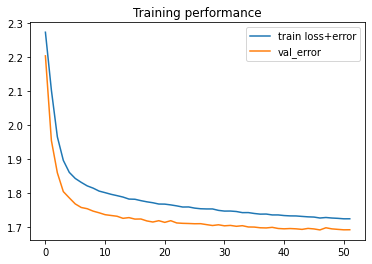

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

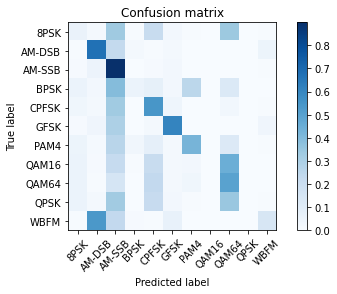

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09074410163339383


Overall Accuracy:  0.09030504379341589


Overall Accuracy:  0.09576703692584809


Overall Accuracy:  0.12062256809338522


Overall Accuracy:  0.13069365882703185


Overall Accuracy:  0.17813641900121802


Overall Accuracy:  0.23926194797338174


Overall Accuracy:  0.3248252810695837


Overall Accuracy:  0.4344287006331022


Overall Accuracy:  0.4796104686548996


Overall Accuracy:  0.4854489164086687


Overall Accuracy:  0.49608669476219147
Overall Accuracy:  0.49226006191950467


Overall Accuracy:  0.4946335479914137


Overall Accuracy:  0.4869431643625192


Overall Accuracy:  0.4830713422007255
Overall Accuracy:  0.49954476479514415


Overall Accuracy:  0.5020833333333333


Overall Accuracy:  0.4887353559627516


Overall Accuracy:  0.49938987187309336


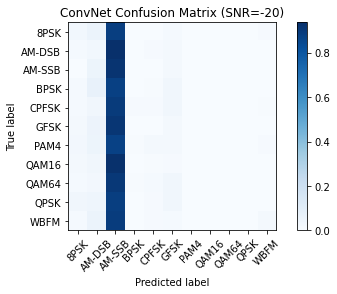

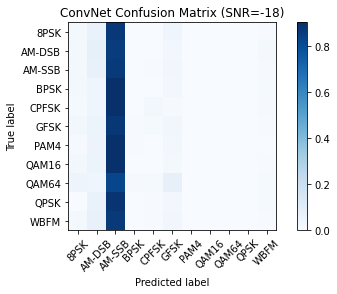

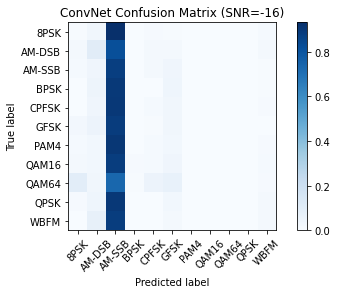

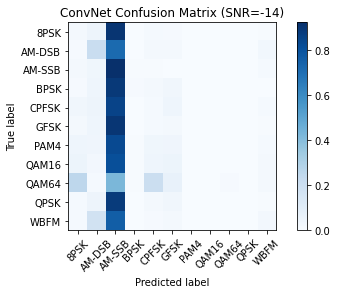

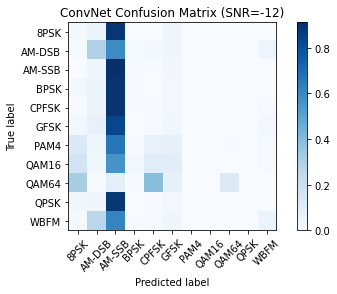

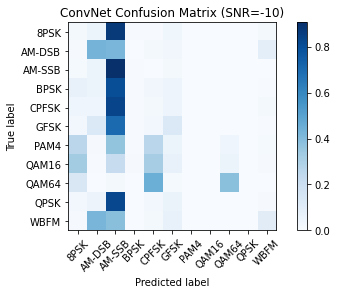

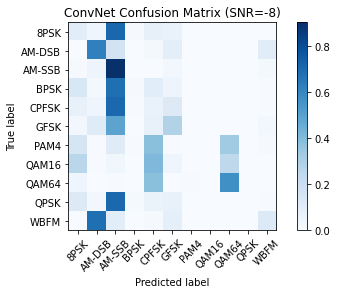

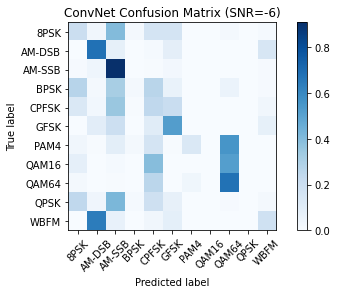

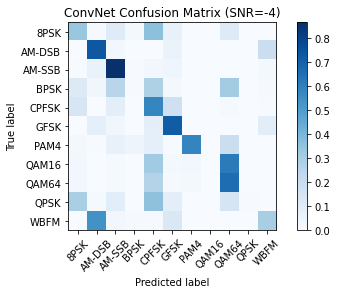

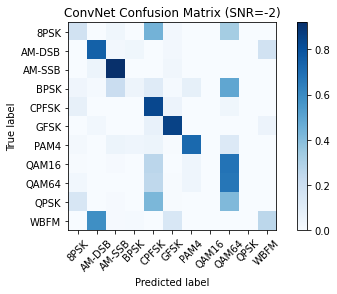

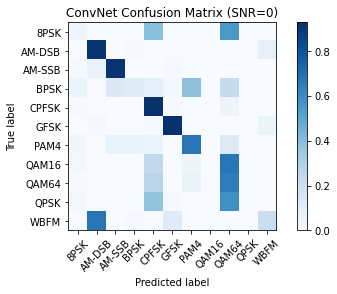

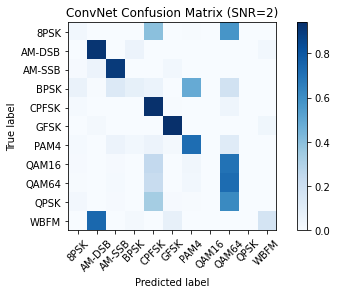

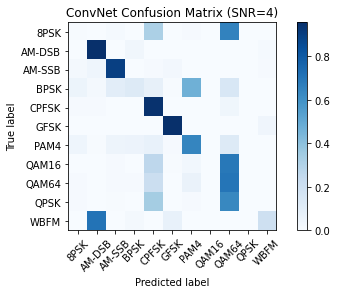

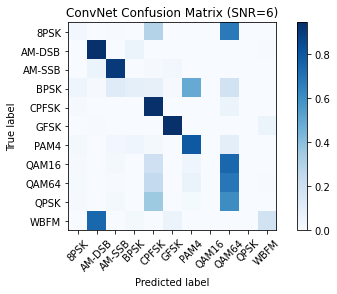

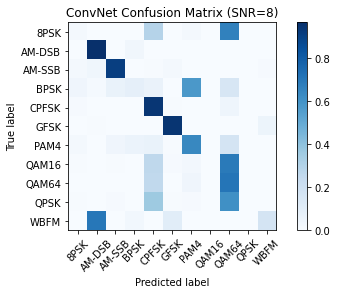

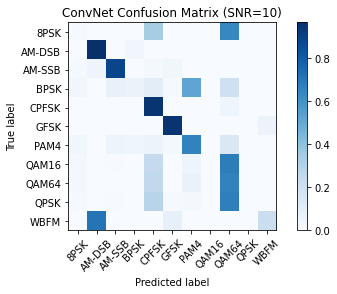

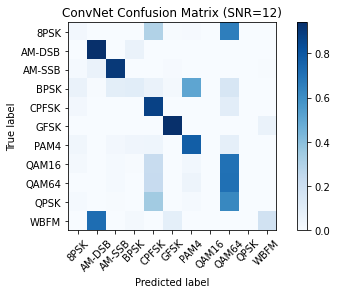

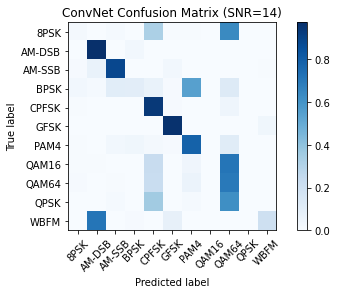

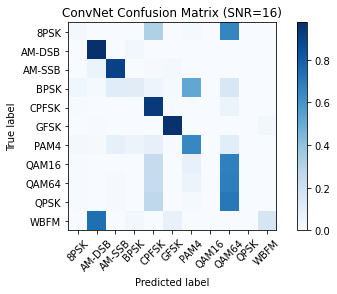

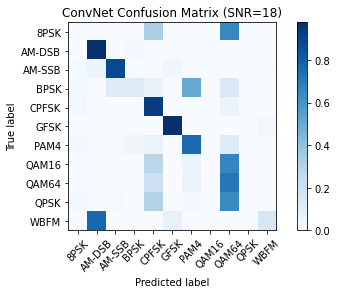

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,12,13,17,23,32,43,47,48,49,49,49,48,48,49,50,48,49


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

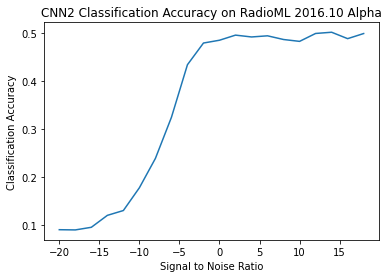

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")